# Browse Basin Soliton Example

---

This example shows how to:

 - Create a kdv scenario case using a measured temperature profile
 - Visualise a single case
 - Run a batch for multiple cases

In [1]:
# Import some standard python routines
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

#
### Import the relevant modules from iwaves
# Density fitting functions
import iwaves.utils.density as density

# Wrapper class for computing the modal functions and input parameters 
from iwaves import IWaveModes

# kdv contains the solver classes, solve_kdv is a wrapper function for calling the class
from iwaves import kdv, solve_kdv 

# NetCDF output viewer class
from iwaves.utils.viewer import viewer

%matplotlib notebook

In [2]:
# Density data inputs
rhofile = '../DATA/Crux_KP150_Phs2_Density_lowpass.csv'

t1 = "20170403"

density_func='double_tanh'

dz = 2.5
zmax = -250.

In [3]:
# Load the density data from the csv file using Pandas
csv = pd.read_csv(rhofile, index_col='Time', parse_dates=True, sep=',')

csv[0:5]

,-250.5,-227.8,-203.6,-179.4,-155.2,-131.0,-106.8,-82.6,-58.4,-34.2,-11.7,-9.7
Time,,,,,,,,,,,,
2016-10-31 06:40:00,1025.8655,1025.6474,1025.4783,1025.2966,1024.6325,1023.7578,1023.2505,1022.5588,1022.0265,1021.6923,1021.1381,1021.1196
2016-10-31 12:40:00,1025.8351,1025.6149,1025.4283,1025.2156,1024.5729,1023.7700,1023.2362,1022.5526,1022.0235,1021.6336,1021.1429,1021.1258
2016-10-31 18:40:00,1025.8092,1025.5864,1025.3866,1025.1397,1024.5233,1023.7797,1023.2174,1022.5417,1022.0155,1021.5780,1021.1477,1021.1317
2016-11-01 00:40:00,1025.7898,1025.5646,1025.3584,1025.0784,1024.4888,1023.7874,1023.1951,1022.5278,1022.0043,1021.5343,1021.1527,1021.1373
2016-11-01 06:40:00,1025.7766,1025.5500,1025.3453,1025.0361,1024.4688,1023.7945,1023.1703,1022.5124,1021.9915,1021.5064,1021.1578,1021.1427


In [4]:
# Pandas allows us to easily index by time
rho = csv["2017-04-01 00:00:00":"2017-04-01 06:00:00"]

# Convert the columns to a depth array
z = np.array([float(ii) for ii in rho.columns])
print z, np.diff(z)

[-250.5 -227.8 -203.6 -179.4 -155.2 -131.  -106.8  -82.6  -58.4  -34.2
  -11.7   -9.7] [ 22.7  24.2  24.2  24.2  24.2  24.2  24.2  24.2  24.2  22.5   2. ]


# Density fitting

Here we derive a full-water column density profile from the discrete point measurements. The [FitDensity](https://bitbucket.org/mrayson/iwaves/src/master/utils/density.py#lines-51) class uses [scipy.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to fit a [double tanh function](https://bitbucket.org/mrayson/iwaves/src/master/utils/density.py#lines-32) using robust least squares.

One could write a separate class and use that instead e.g. a STAN fit!

<IPython.core.display.Javascript object>


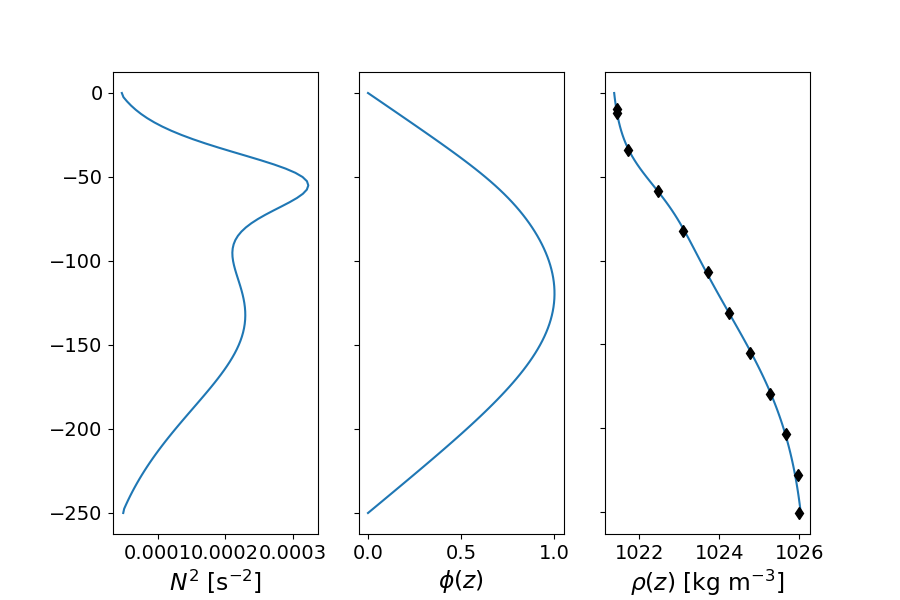

In [5]:
# Now use the IWaveModes class to fit a double tanh function
iw = IWaveModes(rho.values.ravel(), z, 
        density_class=density.FitDensity, # Use the inbuilt fitting class
        density_func='double_tanh', # Use the double density function
               )
# 
phi, c, he, zout = iw(zmax, dz, 0)

# Generate a figure of the density. buoyancy frequency, and phi using the inbuilt plotting method
plt.figure(figsize=(9,6))
iw.plot_modes()

# Create the KdV model class

In [6]:
# User defined function to create the initial conditions
def doublesine(x, a_0, L_w, x0=0.):
    
    k = 2*np.pi/L_w
    k2 = 2*k
    eta =  - a_0 * np.cos(k*x + k*x0 + np.pi/2)
    eta +=  a_0/4. * np.cos(k2*x + k2*x0 + np.pi/2)
    eta[x>x0+3*L_w/2] = 0.
    #eta[x<x0-4*L_w/2] = 0.
    eta[x<x0-L_w/2] = 0.

    return eta


In [7]:
# KdV Input Argurments

dx = 50.
L_d = 3.2e5

mode=0

runtime = 1.5*86400.
ntout = 1800.

outfile = '../DATA/KISSME_KdV_test.nc'
outfile_d = '../DATA/KISSME_KdV_test_diss.nc'

kdvargs = dict(\
    verbose=True,\
    a0=-30.,\
    Lw=None,\
    mode=mode,
    Cmax=0.8,\
    dt=20.,\
    nu_H=0.0,\
    ekdv=False,\
    wavefunc=doublesine,\
    L_d = L_d,
    Nx = int(np.ceil(2*L_d/dx)),
    Ricr=2.0,
    k_diss=1.0,
    )

In [8]:
# Update the wavelength to represent an internal tide
omega = 2*np.pi/(12.42*3600)
k = omega/iw.c1
Lw = 2*np.pi/k
print Lw
kdvargs['Lw'] = Lw
kdvargs['x0'] = -1.5*Lw

52294.3767648


In [9]:
## Test initialising the kdv class
#mykdv0 = kdv.KdVImEx(iw.rhoZ, iw.Z, **kdvargs)
mykdv0 = kdv.KdVDamp(iw.rhoZ, iw.Z, **kdvargs)

mykdv0.print_params()

print 'dx ', mykdv0.dx_s 

print 'Acr: ',mykdv0.A_cr

Parameters:
 c1 = 1.181221
 epsilon = 1.000000
 mu = 1.000000
 r01 = -3711.428299
 r10 = 0.001316
 r20 = 0.0000071

dx  50.0039065552
Acr:  54.9252294287


# Use the wrapper function `kdv_solve` to call the class and save output 

In [10]:
%%time
kdvargs['Ricr'] = 2.0
kdvargs['k_diss'] = 0.0
kdvargs['ekdv'] = False

# Run the model with no dissipation function
mykdv, B = solve_kdv(iw.rhoZ, iw.Z, runtime,\
        solver='damped',
        ntout=ntout, outfile=outfile,\
        **kdvargs)

0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...
CPU times: user 21.3 s, sys: 49.7 ms, total: 21.3 s
Wall time: 21.4 s


In [11]:
%%time
### Call the KdV run function
kdvargs['Ricr'] = 1.0
kdvargs['k_diss'] = 1.0
kdvargs['ekdv'] = False

mykdv_d, B_d = solve_kdv(iw.rhoZ, iw.Z, runtime,\
        solver='damped',
        ntout=ntout, outfile=outfile_d,\
        **kdvargs)

0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...
CPU times: user 20.6 s, sys: 63.6 ms, total: 20.7 s
Wall time: 19.8 s


<IPython.core.display.Javascript object>


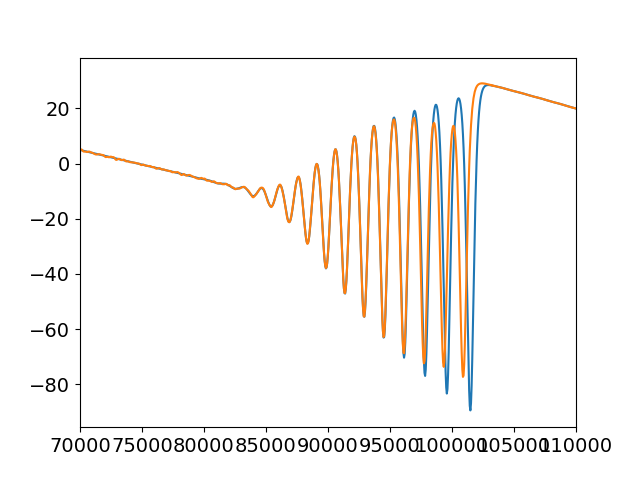

(70000.0, 110000.0)

In [12]:
# Plot the two solutions
plt.figure()
plt.plot(mykdv.x, mykdv.B)
plt.plot(mykdv_d.x, mykdv_d.B)
plt.xlim([7e4,11e4])


<IPython.core.display.Javascript object>


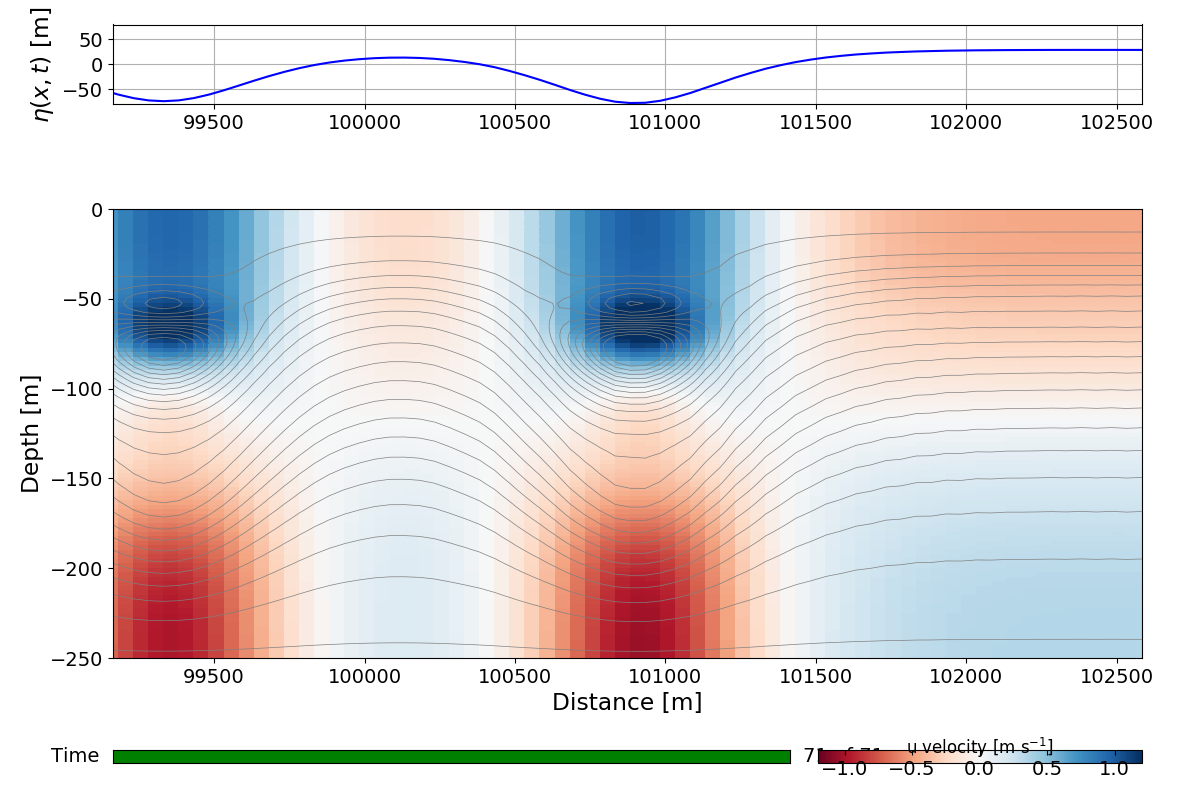

In [18]:
V = viewer(outfile_d, time=-1, xaxis='distance', \
           tstep=-1, xlim=[7e4,11e4], ylim=[-80,80], ulim=1.2,
          density_method='l96')

# Calculate the Ri number

<IPython.core.display.Javascript object>


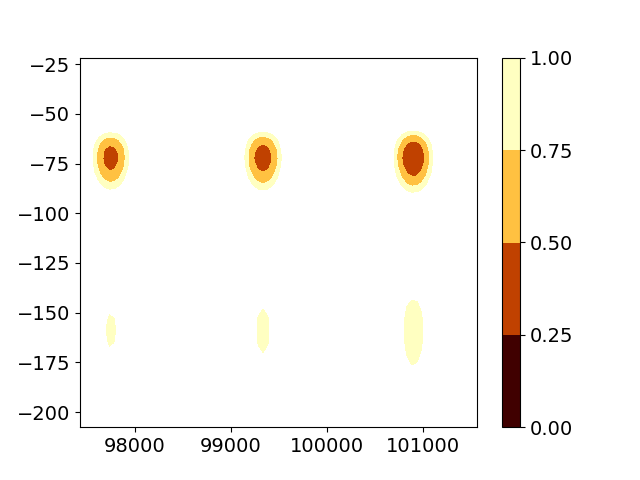

(70000.0, 110000.0)

In [19]:
self = mykdv_d
u,w=self.calc_velocity(nonlinear=True)
uz = np.gradient(u, self.dz, axis=-1)
uz2 = uz*uz

Ri = self.N2[np.newaxis,...] / uz**2
#Ri[uz2<1e-5] = 0.
plt.figure()
plt.contourf(self.x, self.z, Ri.T,np.arange(0,1.25,0.25), cmap='afmhot',  vmin=0, vmax=1)
plt.colorbar()
plt.xlim([7e4,11e4])

# Find the Critical amplitude for the 2nd-order nonlinear problem

$$
u_z^2 = A^2c^2 \phi_{zz}^2 + A^3 2 c^3 \phi_{zz} \phi^{10}_{zz} + A^4 c^4 (\phi^{10}_{zz} )^2 \\
 = \beta_1 A^2 + \beta_2 A^3 + \beta_3 A^4
$$



In [15]:
def solve_Ri( A):
    N2 = self.N2
    Ricr = 1.0
    phi_z = np.gradient(self.phi_1, -self.dz)
    phi_zz = np.gradient(phi_z, -self.dz)

    phi10_z = np.gradient(self.phi10, -self.dz)
    phi10_zz = np.gradient(phi10_z, -self.dz)

    b1 = self.c1**2*phi_zz**2
    b2 = 2*self.c1**3*phi_zz*phi10_zz
    b3 = self.c1**4*phi10_zz**2

    uz2 = b1*A**2 + b2*A**3 + b3*A**4
    soln = np.max(Ricr - N2/uz2)
    return soln

Acr = solve_Ri( 79)
Acr

0.54691223048007664

In [16]:
from scipy.optimize import brentq

#soln = newton_krylov(solve_Ri, 50*np.ones_like(self.N2), rdiff=0.1 )
Asoln = brentq(solve_Ri, 1.,1000., xtol=1e-8)
Asoln

58.20103664603193

In [17]:
brentq?